In [ ]:
import subprocess
 
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)
 
if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
  torch_version_suffix = "+cu110"

CUDA version: 11.1


In [ ]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html
!pip install ftfy regex

import torch

print("Torch version:", torch.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Torch version: 1.7.1+cu110


In [ ]:
#Checking for GPU:
batch_size=50
from torch import cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# make directory to hold images
import os 

#if 'images' not in os.listdir():
#!mkdir /content/images/
# !rm -r /content/images/

# unzip and extract
# !cp -r /content/gdrive/MyDrive/Exotic_Food_Dataset/ExoticFood/ /content/images/
!unzip -uq '/content/gdrive/MyDrive/FinalYearProject-Group11/Datasets/Image_Database_Beverages.zip' -d "/content/images"

In [ ]:
import os
!mkdir data/
!rm -rf data/
!rm -rf data/train
!rm -rf data/test
!rm -rf data/val
!mkdir data/
!mkdir data/train
!mkdir data/test
!mkdir data/val

mkdir: cannot create directory ‘data/’: File exists


In [ ]:
import os
image_urls = []
labels = []

path = '/content/images/Image_Database_Beverages'


for folder in os.listdir(path):
  if folder != '.DS_Store':
    for file in os.listdir(os.path.join(path, folder)):
      if file != '.DS_Store':
        url = os.path.join(path, folder, file)
        image_urls.append(url)
        name = folder#.replace('_',' ')
        labels.append(name)


print(f'# of images: {len(image_urls)}')
print(f'# of labels: {len(labels)}')

# of images: 271
# of labels: 271


In [ ]:
class_to_idx = {v:k for k,v in enumerate(sorted(set(labels)))}
idx_to_class = {k:v for v,k in class_to_idx.items()}

list_of_targets = [class_to_idx[label] for label in labels]

In [ ]:
import pandas as pd
df = pd.DataFrame(list(zip(image_urls, labels, list_of_targets)), columns = ['image_urls', 'labels', 'targets'])

In [ ]:
Names = sorted(set(labels))

In [ ]:
n_classes = len(Names)
print('Number of classes:',n_classes)

Number of classes: 12


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, _, _ = train_test_split(df, df['labels'],stratify=df['labels'], test_size=0.3)
X_test, X_val, _, _ = train_test_split(X_test, X_test['labels'], stratify=X_test['labels'], test_size=0.5)

In [ ]:
X_train['Type'] = 'train'
X_test['Type'] = 'test'
X_val['Type'] = 'val'
df = pd.concat([X_train,X_test, X_val])

In [ ]:
df

,image_urls,labels,targets,Type
204,/content/images/Image_Database_Beverages/V8_Ju...,V8_Juice,10,train
134,/content/images/Image_Database_Beverages/Kool-...,Kool-Aid,5,train
113,/content/images/Image_Database_Beverages/Sunki...,Sunkist,8,train
206,/content/images/Image_Database_Beverages/V8_Ju...,V8_Juice,10,train
210,/content/images/Image_Database_Beverages/V8_Ju...,V8_Juice,10,train
...,...,...,...,...
172,/content/images/Image_Database_Beverages/Welch...,Welchs_Concord_Grape_Juice,11,val
197,/content/images/Image_Database_Beverages/V8_Ju...,V8_Juice,10,val
117,/content/images/Image_Database_Beverages/Sunki...,Sunkist,8,val
64,/content/images/Image_Database_Beverages/Dole_...,Dole_Orange_Juice,2,val


In [ ]:
for name in Names:
  os.system(f"mkdir data/train/'{name}'") 
  os.system(f"mkdir data/test/'{name}'")
  os.system(f"mkdir data/val/'{name}'")

In [ ]:
from shutil import copyfile
for i,row in df.iterrows():
    section = row['Type']
    ipath = row['image_urls']
    #print(ipath, opath)
    opath = ipath.replace(f"images/Image_Database_Beverages/",f"data/{section}/")
    copyfile(ipath, opath)

In [ ]:
traindir = '/content/data/train'
testdir = '/content/data/test'
valdir ='/content/data/val'

In [ ]:
from torchvision import transforms
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=25),
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
from torchvision import datasets
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['test']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['train']), 
    'val':
    datasets.ImageFolder(root=testdir, transform=image_transforms['train'])
} 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow_tensor(image, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image 

In [ ]:
from torch.utils.data import DataLoader
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['test']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=testdir, transform=image_transforms['train'])
}

dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=2),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=2),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True,num_workers=2)
} 

In [ ]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape 

(torch.Size([50, 3, 224, 224]), torch.Size([50]))

In [ ]:
#Model:
from torchvision import models
model = models.resnet50(pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False 

In [ ]:
import torch.nn as nn
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

In [ ]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=12, bias=True)
  (4): LogSoftmax(dim=1)
)

In [ ]:
model = model.to('cuda') 

In [ ]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10] 

[(0, 'Coke _Zero'),
 (1, 'Diet_Dr_Pepper'),
 (2, 'Dole_Orange_Juice'),
 (3, 'Fanta'),
 (4, 'Hawaiian_Punch'),
 (5, 'Kool-Aid'),
 (6, 'Minute_Maid_Orange'),
 (7, 'Snapple_Mango_Madness'),
 (8, 'Sunkist'),
 (9, 'Tropicana_Apple_Juice')]

In [ ]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape) 

torch.Size([256, 2048])
torch.Size([256])
torch.Size([12, 256])
torch.Size([12])


In [ ]:
#Function to train Model:
from timeit import default_timer as timer
def train(model,criterion,optimizer,train_loader, valid_loader, n_epochs=20, print_every=3):
  history = []

  for epoch in range(n_epochs):
    train_loss = 0.0
    train_acc = 0
    valid_loss = 0.0
    valid_acc = 0

    model.train()
    start = timer()

    for i, (data, target) in enumerate(train_loader):
      if train_on_gpu: 
        data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * data.size(0)
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(target.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
      train_acc += accuracy.item() * data.size(0)
    
    else:
      with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
          if train_on_gpu:
            data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
          _, pred = torch.max(output, dim=1)
          correct_tensor = pred.eq(target.data.view_as(pred))
          accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
          valid_acc += accuracy.item()*data.size(0)

  train_loss = train_loss / len(train_loader.dataset)
  train_acc = train_acc / len(train_loader.dataset)
  valid_loss = valid_loss / len(valid_loader.dataset)
  valid_acc = valid_acc / len(valid_loader.dataset)
  history.append([train_loss, train_acc, valid_loss, valid_acc])

  model.optimizer = optimizer
  total_time = timer() 
  history = pd.DataFrame(history,columns=['Train_loss', 'Train_acc', 'Val_loss', 'Val_ac'])

  return model, history

In [ ]:
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'], n_epochs=10)
history

,Train_loss,Train_acc,Val_loss,Val_ac
0,0.507731,0.904762,1.097622,0.682927


In [ ]:
#Function to process an Image path into a Tensor:
from PIL import Image
def process_image(image_path):

    image = Image.open(image_path)
    img = image.resize((256, 256))

    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))
    img = np.array(img).transpose((2, 0, 1)) / 256
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [ ]:
#Function to make predictions on a single image:
def predict(image_path, model, topk=3):
    real_class = image_path.split('/')[-2]

    img_tensor = process_image(image_path)

    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    with torch.no_grad():
        model.eval()
        out = model(img_tensor)
        ps = torch.exp(out)

        #Top 3 predictions
        topk, topclass = ps.topk(topk, dim=1)
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [ ]:
test_pths = os.listdir("/content/data/test/Coke _Zero")
img_path = '/content/data/test/Coke _Zero/'+str(test_pths[0])
#print(test_pths)
img, top_p, top_classes, real_class = predict(img_path, model,topk=3)

['Coke _Zero21.jpg', 'Coke _Zero64.jpg']


In [ ]:
top_p, top_classes

(array([0.43635422, 0.23230177, 0.18297085], dtype=float32),
 ['Coke _Zero', 'Diet_Dr_Pepper', 'Welchs_Concord_Grape_Juice'])

In [ ]:
#Function to display Image and Predictions:
def display_prediction(image_path, model, topk):
    img, ps, classes, y_obs = predict(image_path, model, topk)
    result = pd.DataFrame({'p': ps}, index=classes)
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    #Bar plot
    result.sort_values('p')['p'].plot.barh(color='#2e4d7d', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

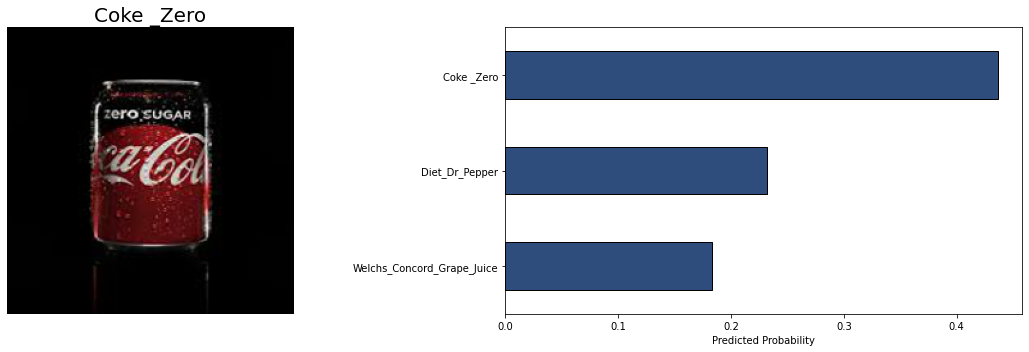

In [ ]:
display_prediction(img_path, model, topk=3)

In [ ]:
def accuracy(output, target, topk=(1, )):
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [ ]:
def evaluate(model, test_loader, criterion, topk=(1, 2, 3)):
    confusion_matrix = torch.zeros(n_classes, n_classes)
    classes = []
    losses = []
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            out = model(data)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
          
            for pred, true in zip(out, targets):
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'}),confusion_matrix

criterion = nn.NLLLoss()

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [ ]:
results, confusion_matrix = evaluate(model, dataloaders['test'], criterion)

Confusion matrix, without normalization


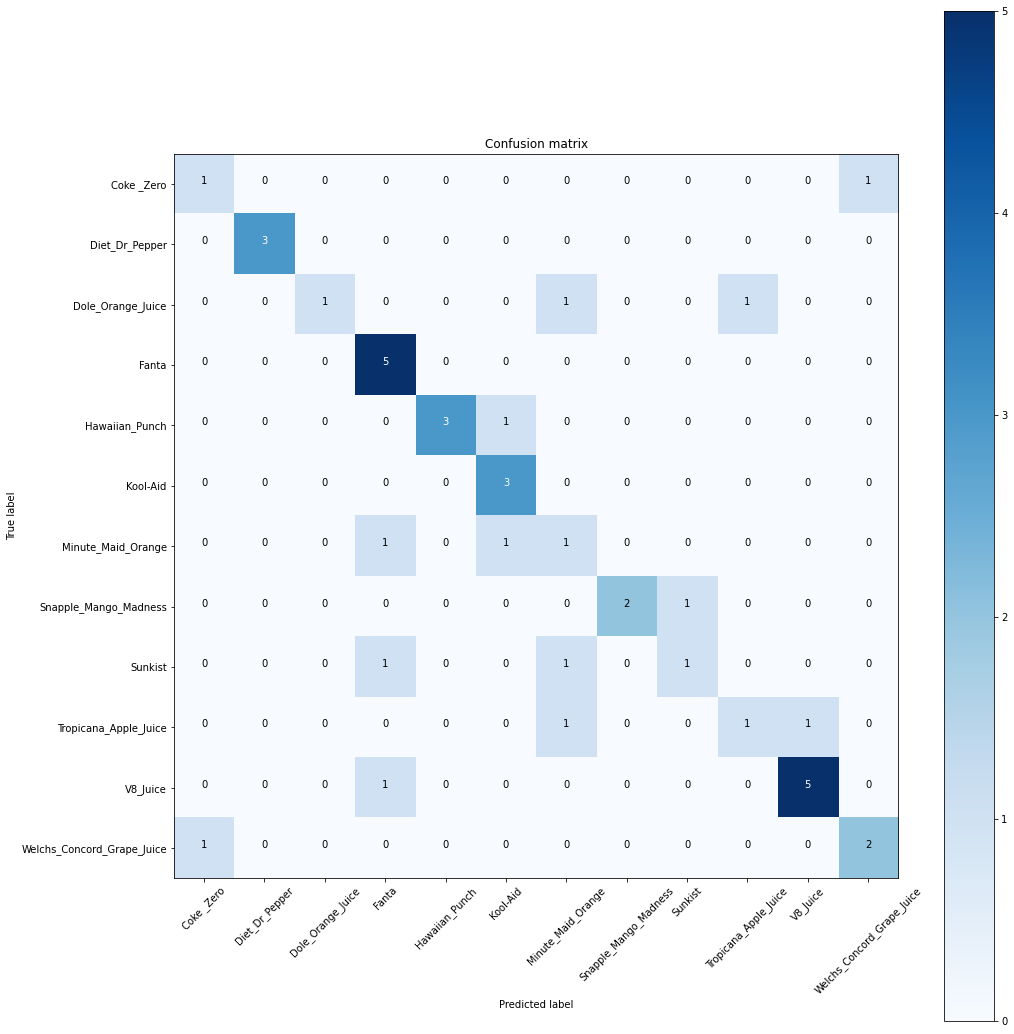

In [ ]:
classnames = [model.idx_to_class[i] for i in range(0,n_classes)]
plt.figure(figsize=(15,15))
plt = plot_confusion_matrix(confusion_matrix, classnames)

In [ ]:
print(f"Overall Accuracy:{(confusion_matrix.diag().sum()/confusion_matrix.sum())*100}%")

Overall Accuracy:68.29268646240234%


In [ ]:
#Model:
from torchvision import models
model2 = models.resnet50(pretrained=False)

In [ ]:
for param in model.parameters():
    param.requires_grad = True 

In [ ]:
import torch.nn as nn
n_inputs = model2.fc.in_features
model2.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

In [ ]:
model2 = model2.to('cuda') 

In [ ]:
model2.class_to_idx = data['train'].class_to_idx
model2.idx_to_class = {
    idx: class_
    for class_, idx in model2.class_to_idx.items()
}

list(model2.idx_to_class.items())[:10] 

[(0, 'Coke _Zero'),
 (1, 'Diet_Dr_Pepper'),
 (2, 'Dole_Orange_Juice'),
 (3, 'Fanta'),
 (4, 'Hawaiian_Punch'),
 (5, 'Kool-Aid'),
 (6, 'Minute_Maid_Orange'),
 (7, 'Snapple_Mango_Madness'),
 (8, 'Sunkist'),
 (9, 'Tropicana_Apple_Juice')]

In [ ]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape) 

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([128, 512, 1, 1])
torch.Size([128])
torch.Siz

In [ ]:
model2, history = train(model2, criterion, optimizer, dataloaders['train'], dataloaders['val'], n_epochs=10)
history

,Train_loss,Train_acc,Val_loss,Val_ac
0,2.519944,0.142857,2.480849,0.04878


#Training a ResNet50 from Scratch

In [ ]:
#Model:
from torchvision import models
model2 = models.resnet50(pretrained=False)

In [ ]:
for param in model.parameters():
    param.requires_grad = True 

In [ ]:
import torch.nn as nn
n_inputs = model2.fc.in_features
model2.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

In [ ]:
model2 = model2.to('cuda') 

In [ ]:
model2.class_to_idx = data['train'].class_to_idx
model2.idx_to_class = {
    idx: class_
    for class_, idx in model2.class_to_idx.items()
}

list(model2.idx_to_class.items())[:10] 

[(0, 'Coke _Zero'),
 (1, 'Diet_Dr_Pepper'),
 (2, 'Dole_Orange_Juice'),
 (3, 'Fanta'),
 (4, 'Hawaiian_Punch'),
 (5, 'Kool-Aid'),
 (6, 'Minute_Maid_Orange'),
 (7, 'Snapple_Mango_Madness'),
 (8, 'Sunkist'),
 (9, 'Tropicana_Apple_Juice')]

In [ ]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape) 

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([128, 512, 1, 1])
torch.Size([128])
torch.Siz

In [ ]:
model2, history = train(model2, criterion, optimizer, dataloaders['train'], dataloaders['val'], n_epochs=10)
history

,Train_loss,Train_acc,Val_loss,Val_ac
0,2.556174,0.095238,2.526237,0.073171


In [ ]:
test_pths = os.listdir("/content/data/test/Coke _Zero")
img_path = '/content/data/test/Coke _Zero/'+str(test_pths[0])
img, top_p, top_classes, real_class = predict(img_path, model2,topk=3)

In [ ]:
top_p, top_classes

(array([0.11403336, 0.10687305, 0.09213369], dtype=float32),
 ['Dole_Orange_Juice', 'Minute_Maid_Orange', 'Tropicana_Apple_Juice'])

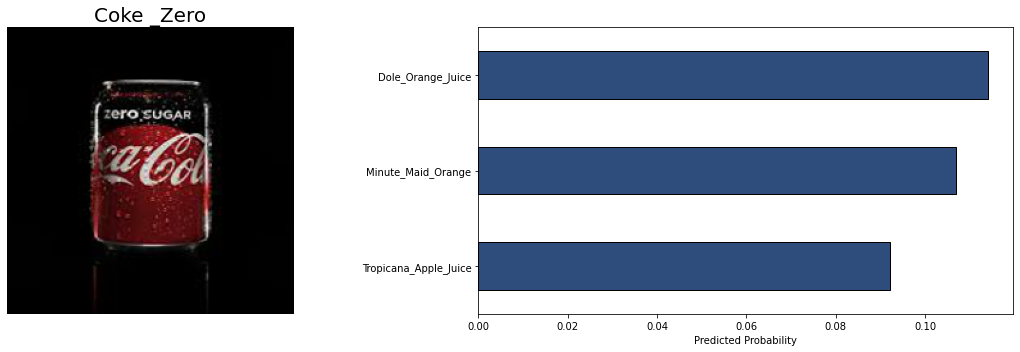

In [ ]:
display_prediction(img_path, model2, topk=3)

In [ ]:
results, confusion_matrix = evaluate(model2, dataloaders['test'], criterion)

Confusion matrix, without normalization


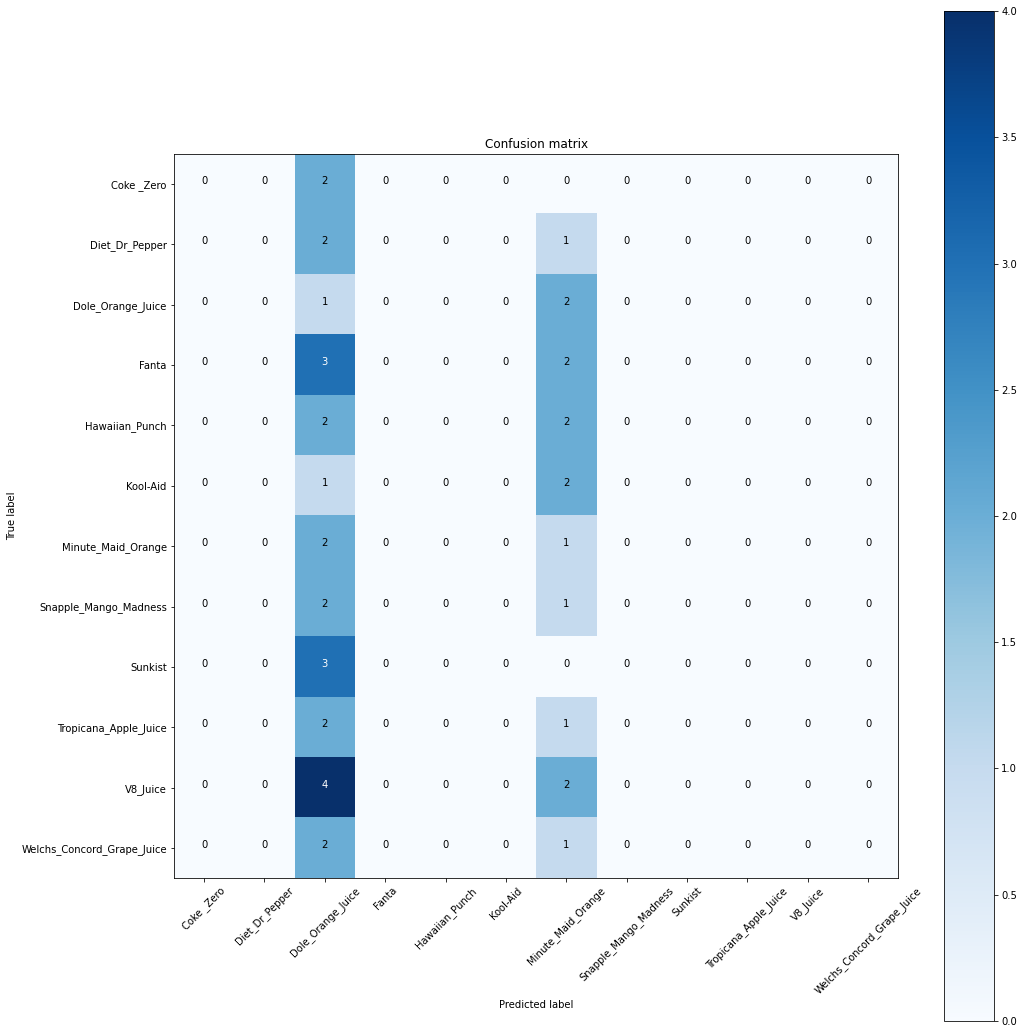

In [ ]:
classnames = [model2.idx_to_class[i] for i in range(0,n_classes)]
plt.figure(figsize=(15,15))
plt = plot_confusion_matrix(confusion_matrix, classnames)

In [ ]:
print(f"Overall Accuracy:{(confusion_matrix.diag().sum()/confusion_matrix.sum())*100}%")

Overall Accuracy:4.878048419952393%
